In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


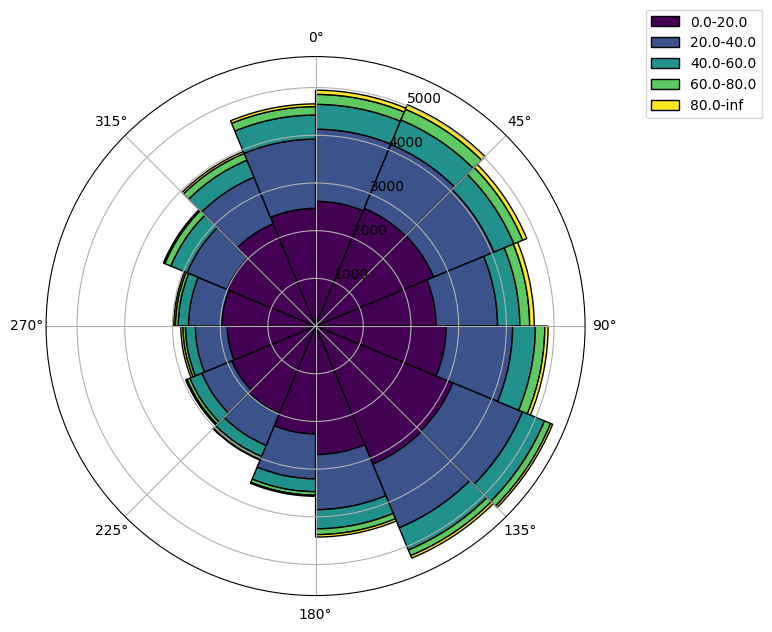

In [3]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


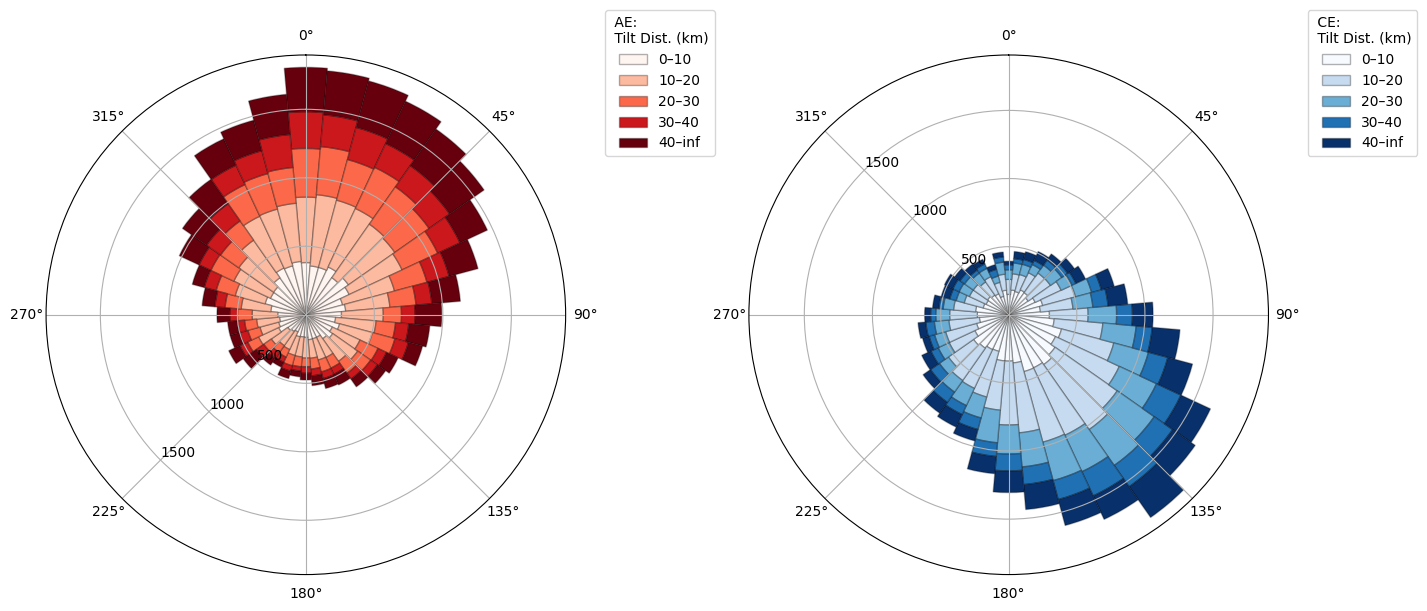

In [4]:
df_AE = df_eddies[df_eddies.Cyc == 'AE'].copy()
df_CE = df_eddies[df_eddies.Cyc == 'CE'].copy()

def choose_dir_bins_cardinal(*dfs, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=8):
    candidates = np.array([4, 6, 8, 9, 10, 12, 15, 16, 18, 20, 24, 30, 36, 45, 60, 72])
    candidates = candidates[(candidates >= min_bins) & (candidates <= max_bins)]
    candidates = candidates[candidates % 4 == 0]  # ensures centres can hit N/E/S/W

    Ns = []
    for df in dfs:
        x = df[col].to_numpy()
        x = x[np.isfinite(x)]
        Ns.append(x.size)
    N = min(Ns) if Ns else 0
    if N == 0 or candidates.size == 0:
        k = 16
    else:
        k0 = int(np.ceil(2 * N ** (1/3)))  # Rice rule
        k = candidates[np.argmin(np.abs(candidates - k0))]

        while k > candidates.min() and (N / k) < min_avg_per_sector:
            k = candidates[candidates < k].max()

    dir_bins = np.linspace(0.0, 360.0, k + 1)
    shift = 180.0 / k  # half-bin shift -> centres at 0, 90, 180, 270
    return dir_bins, shift

# --- bins ---
dir_bins, dir_shift = choose_dir_bins_cardinal(df_AE, df_CE, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=8)
# mag_bins = [0, 20, 40, 60, 80, np.inf]
mag_bins = [0, 10, 20, 30, 40, np.inf]

k = len(dir_bins) - 1
binw_deg = 360.0 / k
angles = np.deg2rad(np.arange(k) * binw_deg)   # centres: 0, binw, 2*binw, ...
width = np.deg2rad(binw_deg)

colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins) - 1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins) - 1))

fig, axs = plt.subplots(
    1, 2,
    subplot_kw={'projection': 'polar'},
    figsize=(14, 6),
    constrained_layout=True
)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = np.mod(df.TiltDir.to_numpy(), 360.0)
    magnitudes = df.TiltDis.to_numpy()
    mask = np.isfinite(directions) & np.isfinite(magnitudes)
    directions = directions[mask]
    magnitudes = magnitudes[mask]

    # shift so bins are centred on N/E/S/W
    directions_s = np.mod(directions + dir_shift, 360.0)

    dir_idx = np.digitize(directions_s, dir_bins, right=False) - 1
    mag_idx = np.digitize(magnitudes, mag_bins, right=False) - 1

    counts = np.zeros((len(mag_bins) - 1, k))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    bottom = np.zeros(k)
    for i in range(counts.shape[0]):
        ax.bar(
            angles, counts[i], width,
            bottom=bottom,
            color=colors1[i] if a == 0 else colors2[i],
            edgecolor=(0, 0, 0, 0.3),
            label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}'
        )
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

    # ax.set_rlabel_position(270)
    ax.set_rticks([500, 1000, 1500])
axs[0].set_rlabel_position(225); axs[1].set_rlabel_position(315)

plt.show()


/scratch/pbs.7500951.kman.restech.unsw.edu.au/ipykernel_2591302/3809179771.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False,


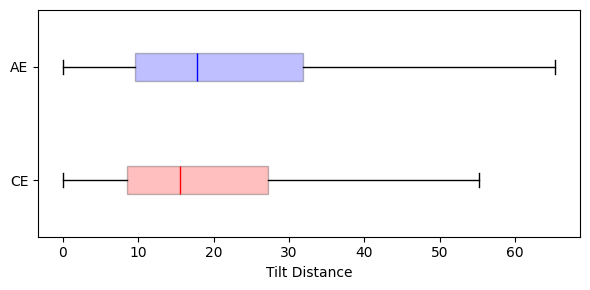

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))

data = []
labels = ['CE', 'AE']
for cyc in labels:
    x = df_eddies.loc[df_eddies.Cyc == cyc, 'TiltDis'].to_numpy()
    x = x[np.isfinite(x)]
    data.append(x)

# vp = ax.violinplot(data, showmeans=False, showmedians=True,
#                    showextrema=False, vert=False)

bp = ax.boxplot(data, labels=labels, showfliers=False,
                widths=0.25, patch_artist=True, vert=False,
                flierprops=dict(marker='x', markersize=6, alpha=0.5))

cols = np.array(['r', 'b'])
for i, b in enumerate(bp['boxes']):
    b.set_facecolor(cols[i])
    b.set_alpha(0.25)
for i, m in enumerate(bp['medians']):
    m.set_color(cols[i])

ax.set_xlabel('Tilt Distance')
plt.tight_layout()
plt.show()



In [5]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()
df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy()
df_AE_ = df_AE_[~df_AE_.TiltDis.isna()]
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy()
df_CE_ = df_CE_[~df_CE_.TiltDis.isna()]

print(f'AE-Days tilt equatorward {((df_AE_.TiltDir>=270) | (df_AE_.TiltDir<=90)).mean()*100:.2f}%')
print(f'AE-Days tilt equator-eastward {((df_AE_[(df_AE_.TiltDir>=270)|(df_AE_.TiltDir<=90)].TiltDir<=90)).mean()*100:.2f}%')
print(f'AE-Days tilt <= 40km {(df_AE_.TiltDis<=40).mean()*100:.2f}%')
print(f'AE-Days tilt >= 80km {(df_AE_.TiltDis>=80).mean()*100:.2f}%')


AE-Days tilt equatorward 69.13%
AE-Days tilt equator-eastward 56.20%
AE-Days tilt <= 40km 83.83%
AE-Days tilt >= 80km 1.69%


In [6]:
print(f'CE-Days tilt poleward {((df_CE_.TiltDir<=270) & (df_CE_.TiltDir>=90)).mean()*100:.2f}%')
print(f'CE-Days tilt poleward-eastward {((df_CE_[(df_CE_.TiltDir<=270) & (df_CE_.TiltDir>=90)].TiltDir<=180)).mean()*100:.2f}%')
print(f'CE-Days tilt <= 40km {(df_CE_.TiltDis<=40).mean()*100:.2f}%')
print(f'CE-Days tilt >= 80km {(df_CE_.TiltDis>=80).mean()*100:.2f}%')


CE-Days tilt poleward 68.38%
CE-Days tilt poleward-eastward 64.06%
CE-Days tilt <= 40km 88.09%
CE-Days tilt >= 80km 0.94%


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


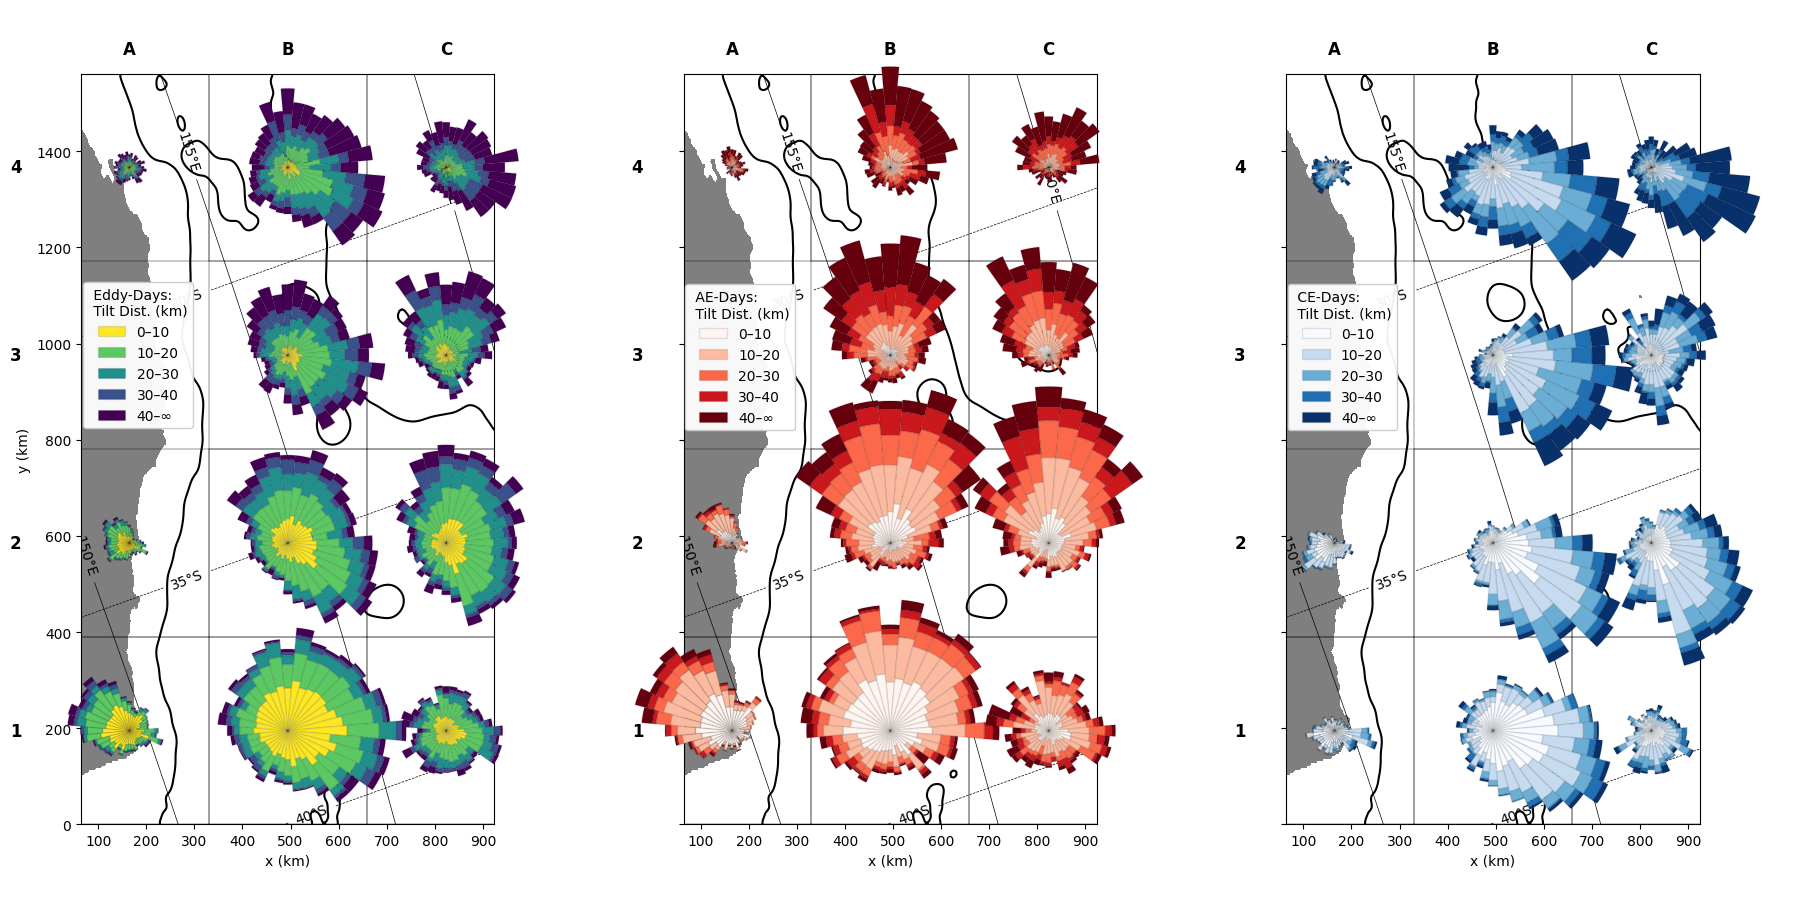

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_AE = df_eddies[df_eddies.Cyc == 'AE'].copy()
df_CE = df_eddies[df_eddies.Cyc == 'CE'].copy()

def choose_dir_bins_cardinal(*dfs, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=8):
    candidates = np.array([4, 6, 8, 9, 10, 12, 15, 16, 18, 20, 24, 30, 36, 45, 60, 72])
    candidates = candidates[(candidates >= min_bins) & (candidates <= max_bins)]
    candidates = candidates[candidates % 4 == 0]

    Ns = []
    for df in dfs:
        x = df[col].to_numpy()
        x = x[np.isfinite(x)]
        Ns.append(x.size)
    N = min(Ns) if Ns else 0

    if N == 0 or candidates.size == 0:
        k = 16
    else:
        k0 = int(np.ceil(2 * N ** (1/3)))
        k = candidates[np.argmin(np.abs(candidates - k0))]
        while k > candidates.min() and (N / k) < min_avg_per_sector:
            k = candidates[candidates < k].max()

    dir_bins = np.linspace(0.0, 360.0, k + 1)
    shift = 180.0 / k
    return dir_bins, shift

# ---------------- grid geometry ----------------
ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols + 1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows + 1)
cell_w = (X_grid.max() - X_grid.min()) / ncols
cell_h = (Y_grid.max() - Y_grid.min()) / nrows

# ---------------- bins ----------------
dir_bins, dir_shift = choose_dir_bins_cardinal(df_AE, df_CE, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=8)
mag_bins = [0, 10, 20, 30, 40, np.inf]

k = len(dir_bins) - 1
binw_deg = 360.0 / k
angles = np.deg2rad(np.arange(k) * binw_deg)
width = np.deg2rad(binw_deg)

colors_cmps = [
    plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins) - 1)),
    plt.cm.Reds(np.linspace(0, 1, len(mag_bins) - 1)),
    plt.cm.Blues(np.linspace(0, 1, len(mag_bins) - 1)),
]

def windrose_counts(directions_deg, magnitudes, *, dir_bins, mag_bins, dir_shift=0.0):
    d = np.asarray(directions_deg, float)
    m = np.asarray(magnitudes, float)
    mask = np.isfinite(d) & np.isfinite(m)
    d = d[mask]; m = m[mask]
    if d.size == 0:
        return None

    d = np.mod(d + dir_shift, 360.0)
    di = np.digitize(d, dir_bins, right=False) - 1
    mi = np.digitize(m, mag_bins, right=False) - 1

    c = np.zeros((len(mag_bins) - 1, len(dir_bins) - 1), float)
    ok = (0 <= di) & (di < c.shape[1]) & (0 <= mi) & (mi < c.shape[0])
    di = di[ok]; mi = mi[ok]
    for d_i, m_i in zip(di, mi):
        c[m_i, d_i] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, *, frac=0.45, tick_flag=False, title='', p=None):
    if c is None:
        return None
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')

    bottom = np.zeros(k)
    for i in range(len(mag_bins) - 1):
        hi = "∞" if np.isinf(mag_bins[i + 1]) else f"{mag_bins[i + 1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor=(0, 0, 0, 0.1), color=colors[i], label=label)
        bottom += c[i]

    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)

    if tick_flag:
        if p == 0:
            bbox_to_anchor = (-.39, -.29)
        elif p == 1:
            bbox_to_anchor = (-.17, -.1)
        elif p == 2:
            bbox_to_anchor = (-.17, -.1) #(-.25, -.15)
        else:
            bbox_to_anchor = (0, 0)
        iax.legend(title=title, loc='center left', frameon=True, fontsize=10, title_fontsize=10,
                   bbox_to_anchor=bbox_to_anchor, framealpha=.95)

    iax.set_xticks([])
    iax.set_yticks([])
    iax.set_frame_on(False)
    return iax

def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i + 1]
            y0, y1 = y_edges[j], y_edges[j + 1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]

            d = np.asarray((sub.TiltDir.to_numpy() - 20.0) % 360.0, float)
            m = np.asarray(sub.TiltDis.to_numpy(), float)

            c = windrose_counts(d, m, dir_bins=dir_bins, mag_bins=mag_bins, dir_shift=dir_shift)
            out[(i, j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 2.0]
fig, axs = plt.subplots(1, 3, figsize=(18, 9), sharey=True)

titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

    counts_map, rmax = cell_counts(df)

    for i in range(ncols):
        for j in range(nrows):
            if (i == 0) and (j == 2):
                continue

            x0, x1 = x_edges[i], x_edges[i + 1]
            y0, y1 = y_edges[j], y_edges[j + 1]
            xc, yc = 0.5 * (x0 + x1), 0.5 * (y0 + y1)

            tick_flag = (i == 1) and (j == 3)
            add_windrose(ax, xc, yc, counts_map[(i, j)], rmax, colors_cmps[p],
                         frac=fracs[p], tick_flag=tick_flag,
                         title=' ' + titles[p] + ':\n Tilt Dist. (km)', p=p)

            if (i == 0) and (j == 2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i, j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i, j)], rmax/10, colors_cmps[p], frac=fracs[p])

            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xmid = 0.5 * (x_edges[i] + x_edges[i + 1])
        ax.text(xmid, y_edges[-1] + 0.02 * (Y_grid.max() - Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        ymid = 0.5 * (y_edges[j] + y_edges[j + 1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha * (X_grid.max() - X_grid.min()), ymid,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


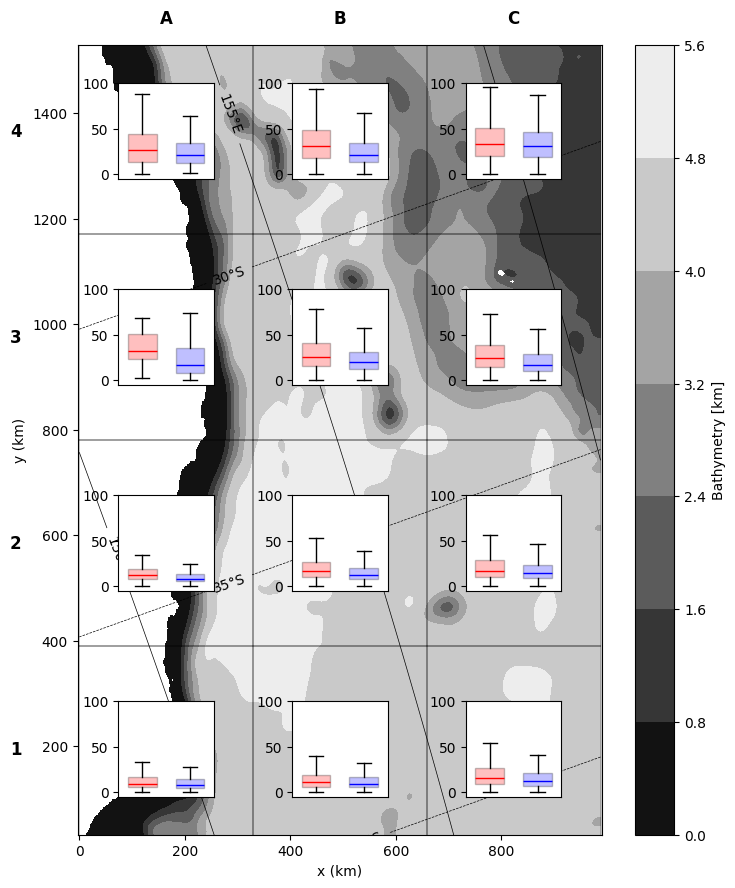

In [80]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_AE = df_eddies[df_eddies.Cyc == 'AE'].copy()
df_CE = df_eddies[df_eddies.Cyc == 'CE'].copy()

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols + 1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows + 1)
cell_w = (X_grid.max() - X_grid.min()) / ncols
cell_h = (Y_grid.max() - Y_grid.min()) / nrows

def add_cell_boxplot_AE_CE(ax, x0, y0, x_AE, x_CE, *, frac=0.5, colors=('r','b'), ylim=(-10, 100)):
    x_AE = np.asarray(x_AE, float); x_AE = x_AE[np.isfinite(x_AE)]
    x_CE = np.asarray(x_CE, float); x_CE = x_CE[np.isfinite(x_CE)]
    if (x_AE.size == 0) and (x_CE.size == 0):
        return None

    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)

    data = []
    pos = []
    if x_AE.size:
        data.append(x_AE); pos.append(1)
    if x_CE.size:
        data.append(x_CE); pos.append(2)

    bp = iax.boxplot(
        data,
        positions=pos,
        vert=True,
        widths=0.6,
        patch_artist=True,
        showfliers=False,
        flierprops=dict(marker='.', markersize=4, alpha=.6)
    )

    # colour per group (AE then CE if present)
    cols = []
    if x_AE.size: cols.append(colors[0])
    if x_CE.size: cols.append(colors[1])

    for i, b in enumerate(bp['boxes']):
        b.set_facecolor(cols[i])
        b.set_alpha(.25)
    for i, m in enumerate(bp['medians']):
        m.set_color(cols[i])

    iax.set_xlim(0.5, 2.5)
    iax.set_xticks([])
    iax.set_ylim(-5, 100)
    # iax.set_frame_on(False)
    # iax.set_yticks([])
    return iax

fig, ax = plt.subplots(1, 1, figsize=(7.5, 9), constrained_layout=False)

cf = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='gray')
cbar = fig.colorbar(cf, ax=ax, location='right', label='Bathymetry [km]')
c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax.axis('equal')
ax.set_xlim(X_grid.min(), X_grid.max())
ax.set_ylim(Y_grid.min(), Y_grid.max())

frac = 0.55
for i in range(ncols):
    for j in range(nrows):
        x0, x1 = x_edges[i], x_edges[i + 1]
        y0, y1 = y_edges[j], y_edges[j + 1]
        xc, yc = 0.5 * (x0 + x1), 0.5 * (y0 + y1)

        sub_AE = df_AE[(df_AE.xc >= x0) & (df_AE.xc < x1) & (df_AE.yc >= y0) & (df_AE.yc < y1)]
        sub_CE = df_CE[(df_CE.xc >= x0) & (df_CE.xc < x1) & (df_CE.yc >= y0) & (df_CE.yc < y1)]

        add_cell_boxplot_AE_CE(ax, xc, yc,
                               sub_AE.TiltDis.to_numpy(),
                               sub_CE.TiltDis.to_numpy(),
                               frac=frac, colors=('r', 'b'), ylim=(-10, 100))

        ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

col_labels = ['A', 'B', 'C', 'D']
for i in range(ncols):
    xmid = 0.5 * (x_edges[i] + x_edges[i + 1])
    ax.text(xmid, y_edges[-1] + 0.02 * (Y_grid.max() - Y_grid.min()) - 30,
            col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

for j in range(nrows):
    ymid = 0.5 * (y_edges[j] + y_edges[j + 1])
    ax.text(x_edges[0] - 0.06 * (X_grid.max() - X_grid.min())-50, ymid,
            f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')

# tiny legend in axis coords
ax.plot([], [], color='r', lw=6, alpha=.25, label='AE')
ax.plot([], [], color='b', lw=6, alpha=.25, label='CE')
# ax.legend(loc='lower left', frameon=True, framealpha=.9)
ax.set_xlim(40, X_grid.max()-40)
ax.set_ylim(40, Y_grid.max()-40)

# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
# ax.tick_params(axis="y", labelright=True, labelleft=False)

plt.tight_layout()
plt.show()